In [65]:
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

warnings.filterwarnings('ignore')

In [66]:
class Config:
    TRAINING_FILE = "../input/train_data_2000.csv"
    CONTACT_FILE = "../input/contact_data_2000.csv"
    TEST_FILE = "../input/test_data_2000.csv"
    MODEL_OUTPUT = "../models/"
    PROCESSED_DATA_OUTPUT = "../input/processed_data.csv"


config = Config()

In [67]:
test = pd.read_csv(config.TEST_FILE)
train = pd.read_csv(config.TRAINING_FILE)
contact = pd.read_csv(config.CONTACT_FILE)

In [68]:
contact.head()

,chr1,start1,end1,chr2,start2,end2,cellid
0,chr13-M,74316813,74316959,chr13-M,72727004,72727154,SCG0088_TTTAACCTCAGCCAAT-1
1,chr1-M,79322530,79322563,chr12-M,4538118,4538268,SCG0088_TATAGGTGTCCCGGAA-1
2,chr2-M,75633331,75633491,chr8-P,125695812,125695962,SCG0088_CGTTAACAGTACCGCA-1
3,chr7-P,136324163,136324313,chr7-P,136352442,136352592,SCG0088_TTTAACCTCAGCCAAT-1
4,chr6-M,49253365,49253515,chr6-M,49323546,49323680,SCG0088_CGTTAACAGTACCGCA-1


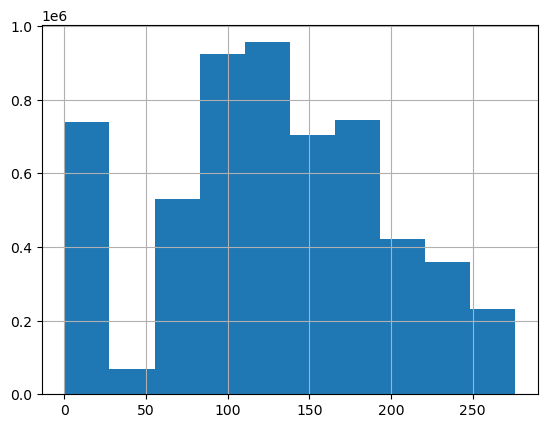

In [69]:
contact['intra'] = (contact['chr1'] == contact['chr2']).astype(int)

contact['log_dist'] = np.where(contact['intra'] == 1, (np.log2(
    np.abs(contact['end2'] - contact['end1']) + 1) + 0.1) / 0.1, 0)

contact['log_dist'].hist()

n = (contact['log_dist'] > 0).sum()
bins = [-1, 0, 50, 100, 150, 200, 250, 300]
labels = ['0', '0-50', '50-100', '100-150', '150-200', '200-250', '250-300']
contact['log_dist_bin'] = pd.cut(
    contact['log_dist'], bins=bins, labels=labels)


prob_df = contact.groupby(['cellid', 'log_dist_bin']
                          ).size().unstack(fill_value=0)
prob_df = prob_df.div(prob_df.sum(axis=1), axis=0)

train = train.merge(prob_df, on='cellid', how='left')

<Axes: >

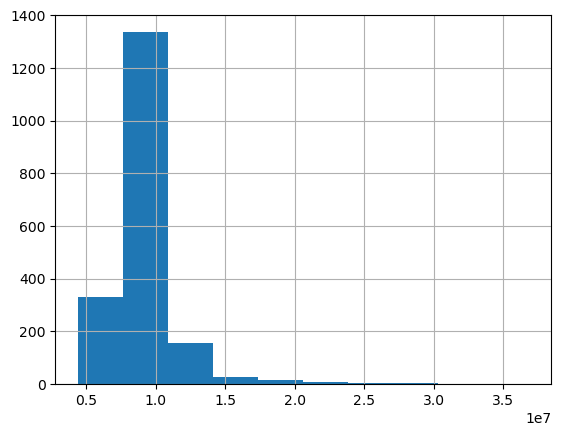

In [70]:
contact["dist"] = np.abs(contact["start1"] - contact["start2"])
dists = contact.groupby('cellid')['dist'].mean()
dists_grouped = pd.cut(dists, bins=[-np.inf, 80, 90, np.inf], labels=[0, 1, 2])

train = train.merge(dists_grouped.rename(
    'dist_grouped'), on='cellid', how='left')

dists.hist()

In [71]:
total_contacts = contact.groupby('cellid').size().rename('total_contacts')
train = train.merge(total_contacts, on='cellid', how='left')

In [72]:
# def calculate_inter_chrom_pct(cell_contacts):
#     total_contacts = len(cell_contacts)
#     if total_contacts == 0:
#         return 0.0
#     inter_contacts = sum(cell_contacts['chr1'] != cell_contacts['chr2'])
#     return (inter_contacts / total_contacts)

# inter_pct = contact.groupby('cellid').apply(
#     calculate_inter_chrom_pct).reset_index()
# inter_pct.columns = ['cellid', 'inter_chrom_pct']

# train = train.merge(inter_pct, on='cellid', how='left')

In [73]:
# Intra vs Inter contacts proportions
contact_type = contact.groupby(
    ['cellid', 'intra']).size().unstack(fill_value=0)
contact_type['intra_ratio'] = contact_type[1] / \
    (contact_type[0] + contact_type[1])
train = train.merge(
    contact_type[['intra_ratio']], on='cellid', how='left')

In [74]:
contact_type

intra,0,1,intra_ratio
cellid,,,
SCG0088_AAAGGACGTTAACGGC-1,675,3179,0.824857
SCG0088_AAATCCGGTGACATAT-1,302,2296,0.883757
SCG0088_AACAGCAAGACAGGCG-1,283,2165,0.884395
SCG0088_AACATCATCAGGTTTA-1,525,5228,0.908743
SCG0088_AACCTTAAGCTGCACA-1,331,1965,0.855836
...,...,...,...
SCG0093_TTTGACTTCAAGGACA-1,314,1792,0.850902
SCG0093_TTTGAGTCAATGCGCT-1,348,1856,0.842105
SCG0093_TTTGCGGAGGATGATG-1,340,1787,0.840150


In [75]:
# def get_nearest_contacts_features(contact, N=5):
#     contact_sorted = contact.sort_values(by=['cellid', 'chr1', 'start1'])

#     contact_sorted['neighbor_contacts'] = (
#         contact_sorted.groupby(['cellid', 'chr1'])['cellid']
#         .transform(lambda x: x.rolling(N, min_periods=1).count())
#     )

#     contact_sorted['neighbor_intra_ratio'] = (
#         contact_sorted.groupby(['cellid', 'chr1'])['intra']
#         .transform(lambda x: x.rolling(N, min_periods=1).mean())
#     )

#     contact_sorted['neighbor_close_ratio'] = (
#         contact_sorted.groupby(['cellid', 'chr1'])['log_dist']
#         .transform(lambda x: (x < 100).rolling(N, min_periods=1).mean())
#     )

#     neighbor_features = contact_sorted[[
#         'cellid', 'neighbor_contacts', 'neighbor_intra_ratio', 'neighbor_close_ratio']]
#     neighbor_features = neighbor_features.groupby(
#         'cellid').mean().reset_index()

#     return neighbor_features


# neighbor_features = get_nearest_contacts_features(contact, N=5)

# train = train.merge(neighbor_features, on='cellid', how='left')

In [76]:
contact

,chr1,start1,end1,chr2,start2,end2,cellid,intra,log_dist,log_dist_bin,dist
0,chr13-M,74316813,74316959,chr13-M,72727004,72727154,SCG0088_TTTAACCTCAGCCAAT-1,1,207.004193,200-250,1589809
1,chr1-M,79322530,79322563,chr12-M,4538118,4538268,SCG0088_TATAGGTGTCCCGGAA-1,0,0.000000,0,74784412
2,chr2-M,75633331,75633491,chr8-P,125695812,125695962,SCG0088_CGTTAACAGTACCGCA-1,0,0.000000,0,50062481
3,chr7-P,136324163,136324313,chr7-P,136352442,136352592,SCG0088_TTTAACCTCAGCCAAT-1,1,148.874945,100-150,28279
4,chr6-M,49253365,49253515,chr6-M,49323546,49323680,SCG0088_CGTTAACAGTACCGCA-1,1,161.984845,150-200,70181
...,...,...,...,...,...,...,...,...,...,...,...
5679069,chr12-P,104620937,104621003,chr12-P,64688195,64688345,SCG0093_GCGATTTAGGCGCTAC-1,1,253.510658,250-300,39932742
5679070,chr12-P,34306015,34306042,chr12-P,34303888,34303918,SCG0093_AATCAGGAGCTCCTAC-1,1,111.532471,100-150,2127
5679071,chr2-P,123666481,123666505,chr2-P,136717359,136717509,SCG0093_CCTGGTAAGGCGGGTA-1,1,237.376576,200-250,13050878
5679072,chr15-P,38079409,38079445,chr15-P,38079626,38079723,SCG0093_AATCAGGAGCTCCTAC-1,1,82.241213,50-100,217


In [77]:
# Proportions within intra-chromosomal contacts only
intra_contact = contact[contact['intra'] == 1].copy()
intra_bins = intra_contact.groupby(
    ['cellid', 'log_dist_bin']).size().unstack(fill_value=0)
intra_bins = intra_bins.div(intra_bins.sum(axis=1), axis=0)
intra_bins.columns = [f'intra_{col}' for col in intra_bins.columns]
train = train.merge(intra_bins, on='cellid', how='left')

In [78]:
# short-range (<200) vs long-range (>=200)
train['short_range_ratio'] = train[[
    '0-50', '50-100', '100-150', '150-200']].sum(axis=1)
train['long_range_ratio'] = train[['200-250', '250-300']].sum(axis=1)
train['short_long_ratio'] = train['short_range_ratio'] / \
    (train['long_range_ratio'] + 1e-6)

In [79]:
# chr_counts = (
#     contact.melt(id_vars=['cellid'],
#                  value_vars=['chr1', 'chr2'],
#                  value_name='chr')
#     .groupby(['cellid', 'chr'])
#     .size()
#     .unstack(fill_value=0)
# )
# chr_counts = chr_counts.add_prefix('contacts_')
# train = train.merge(chr_counts, on='cellid', how='left')

In [80]:
contact.head()

,chr1,start1,end1,chr2,start2,end2,cellid,intra,log_dist,log_dist_bin,dist
0,chr13-M,74316813,74316959,chr13-M,72727004,72727154,SCG0088_TTTAACCTCAGCCAAT-1,1,207.004193,200-250,1589809
1,chr1-M,79322530,79322563,chr12-M,4538118,4538268,SCG0088_TATAGGTGTCCCGGAA-1,0,0.000000,0,74784412
2,chr2-M,75633331,75633491,chr8-P,125695812,125695962,SCG0088_CGTTAACAGTACCGCA-1,0,0.000000,0,50062481
3,chr7-P,136324163,136324313,chr7-P,136352442,136352592,SCG0088_TTTAACCTCAGCCAAT-1,1,148.874945,100-150,28279
4,chr6-M,49253365,49253515,chr6-M,49323546,49323680,SCG0088_CGTTAACAGTACCGCA-1,1,161.984845,150-200,70181


In [81]:
train.shape

(1501, 24)

In [82]:
# # probably it is decreasing accuracy :()

# chr1_chr2_contacts = contact.groupby(
#     "chr1")["chr2"].size().rename("chr1_chr2_count")
# chr2_chr1_contacts = contact.groupby(
#     "chr2")["chr1"].size().rename("chr2_chr1_count")

# total_contacts = len(contact)

# chr1_chr2_contacts_percentage = (
#     chr1_chr2_contacts / total_contacts * 100).rename("chr1_chr2_percentage")
# chr2_chr1_contacts_percentage = (
#     chr2_chr1_contacts / total_contacts * 100).rename("chr2_chr1_percentage")

# contact = contact.merge(chr1_chr2_contacts_percentage, on="chr1", how="left")
# contact = contact.merge(chr2_chr1_contacts_percentage, on="chr2", how="left")

# cont_per1 = contact.groupby('cellid', as_index=False)[
#     'chr1_chr2_percentage'].count()
# cont_per2 = contact.groupby('cellid', as_index=False)[
#     'chr2_chr1_percentage'].count()


# train = train.merge(cont_per1, on='cellid', how='left')
# train = train.merge(cont_per2, on='cellid', how='left')

In [83]:
# from scipy.stats import skew, kurtosis

# contact["distance"] = abs(contact["start1"] - contact["start2"])

# dfc = contact.groupby("cellid", as_index=False).agg(
#     mean_distance=("distance", "mean"),
#     std_distance=("distance", "std"),
#     skew_distance=("distance", lambda x: skew(x, bias=False)),
#     kurtosis_distance=("distance", lambda x: kurtosis(x, bias=False)),
#     start_range=("start1", lambda x: np.percentile(
#         x, 95) - np.percentile(x, 5)),
#     mean_pos=("start1", "mean"),
#     std_pos=("start1", "std"),
#     skew_pos=("start1", lambda x: skew(x, bias=False)),
#     kurtosis_pos=("start1", lambda x: kurtosis(x, bias=False)),
#     start_Q3_Q1=("start1", lambda x: np.percentile(
#         x, 75) - np.percentile(x, 25)),
#     distance_range=("distance", lambda x: np.percentile(
#         x, 95) - np.percentile(x, 5)),
#     distance_Q3_Q1=("distance", lambda x: np.percentile(
#         x, 75) - np.percentile(x, 25))
# ).reset_index()

# train = train.merge(dfc, on='cellid', how='left')

In [84]:
# from scipy.stats import entropy
# intra_contacts = contact[contact['log_dist'] > 0]

# agg_stats = intra_contacts.groupby('cellid')['log_dist'].agg(
#     mean_log_dist='mean',
#     std_log_dist='std'
# ).reset_index()

# train = train.merge(agg_stats, on='cellid', how='left')


# log_dist_bin_distribution = contact.groupby(
#     'cellid')['log_dist_bin'].value_counts(normalize=True).unstack(fill_value=0)
# log_dist_bin_entropy = log_dist_bin_distribution.apply(
#     entropy, axis=1).reset_index()
# log_dist_bin_entropy.columns = ['cellid', 'entropy']

# train = train.merge(log_dist_bin_entropy, on='cellid', how='left')

In [85]:
train.columns

Index(['cellid', 'phase', 'order_within_phase', 'order', '0', '0-50', '50-100',
       '100-150', '150-200', '200-250', '250-300', 'dist_grouped',
       'total_contacts', 'intra_ratio', 'intra_0', 'intra_0-50',
       'intra_50-100', 'intra_100-150', 'intra_150-200', 'intra_200-250',
       'intra_250-300', 'short_range_ratio', 'long_range_ratio',
       'short_long_ratio'],
      dtype='object')

In [86]:
train.head()

,cellid,phase,order_within_phase,order,0,0-50,50-100,100-150,150-200,200-250,...,intra_0,intra_0-50,intra_50-100,intra_100-150,intra_150-200,intra_200-250,intra_250-300,short_range_ratio,long_range_ratio,short_long_ratio
0,SCG0088_CTATGAGGTACCGGAT-1,G1,0,0,0.106918,0.004324,0.150943,0.342767,0.223664,0.116352,...,0.0,0.004842,0.169014,0.383803,0.250440,0.130282,0.061620,0.721698,0.171384,4.210985
1,SCG0088_GCTAAGCGTATTGGTG-1,G1,0,0,0.117595,0.009354,0.251225,0.271715,0.198218,0.106904,...,0.0,0.010601,0.284705,0.307925,0.224634,0.121151,0.050984,0.730512,0.151893,4.809353
2,SCG0089_TCCATTGTCTGTAAGC-1,G1,0,0,0.117763,0.005888,0.226202,0.301766,0.236997,0.084396,...,0.0,0.006674,0.256396,0.342047,0.268632,0.095662,0.030590,0.770854,0.111384,6.920643
3,SCG0092_GTTTATCTCATGCTAA-1,G1,0,0,0.103506,0.003362,0.175793,0.328050,0.191162,0.125360,...,0.0,0.003750,0.196089,0.365926,0.213233,0.139834,0.081168,0.698367,0.198127,3.524831
4,SCG0092_AACCGCTCAGCTCATA-1,G1,0,0,0.148919,0.011424,0.246430,0.302326,0.197470,0.064055,...,0.0,0.013423,0.289549,0.355225,0.232023,0.075264,0.034516,0.757650,0.093431,8.109084


In [87]:
train.isnull().sum()

cellid                0
phase                 0
order_within_phase    0
order                 0
0                     0
0-50                  0
50-100                0
100-150               0
150-200               0
200-250               0
250-300               0
dist_grouped          0
total_contacts        0
intra_ratio           0
intra_0               0
intra_0-50            0
intra_50-100          0
intra_100-150         0
intra_150-200         0
intra_200-250         0
intra_250-300         0
short_range_ratio     0
long_range_ratio      0
short_long_ratio      0
dtype: int64

In [88]:
train.fillna(0, inplace=True)

In [89]:
train.shape

(1501, 24)

In [90]:
from sklearn.feature_selection import SelectKBest
X = train.drop(['cellid', 'phase', 'order', 'order_within_phase'], axis=1)
y = train['phase']

X_new = SelectKBest(k=22).fit_transform(X, y)
new_features_df = pd.DataFrame(
    X_new, columns=[f'feature_{i}' for i in range(X_new.shape[1])])
new_features_df['phase'] = y.values

In [91]:
train.columns

Index(['cellid', 'phase', 'order_within_phase', 'order', '0', '0-50', '50-100',
       '100-150', '150-200', '200-250', '250-300', 'dist_grouped',
       'total_contacts', 'intra_ratio', 'intra_0', 'intra_0-50',
       'intra_50-100', 'intra_100-150', 'intra_150-200', 'intra_200-250',
       'intra_250-300', 'short_range_ratio', 'long_range_ratio',
       'short_long_ratio'],
      dtype='object')

In [ ]:
train.drop(columns=['intra_0', 'dist_grouped'], inplace=True)

In [93]:
# Save after processing
train.to_csv(config.PROCESSED_DATA_OUTPUT, index=False)